## The game plan

1. Set up lab environment
    1. Plug into Quantl https://s3.amazonaws.com/quantstart/media/powerpoint/an-introduction-to-backtesting.pdf
        1. Set up targets
        2. Set up predictions via volume/time series analysis
    2. Plug in scraper
        1. Get one news source - start with __newspaper__
        2. Plug in Google NLP thingymajigger
        3. Maybe IBM thingymajigger

starting stocks:
square
amd
tesla

datasets:
- new york times corpus - 2987 - 2007
    - https://catalog.ldc.upenn.edu/ldc2008t19

scraping:
- https://www.smallsurething.com/web-scraping-article-extraction-and-sentiment-analysis-with-scrapy-goose-and-textblob/
    - use scrapy to build a per site scraper
- go through event registry's article database
    -https://github.com/EventRegistry/event-registry-python
- use newspaper to get articles
    - http://newspaper.readthedocs.io/en/latest/
    
commercial nlp solutions:
- https://www.ibm.com/watson/services/tone-analyzer/
- https://cloud.google.com/natural-language/



- possible data
    - news articles + meta data - counts, etc
        - possibly per industry
    - volume
    - as triggered by earnings call or news release
    - possibly seeing source of volume?
- get targets
    - stock events - buy --> sell in 3 months. maybe sell in 1 year?
        - buy screening event - rapid drop over 1-7 days (plus high 'panic' amount)
        
notes:
- targets need to be if there will be rise after the open of next day, not the closing of the day before

# Getting targets
### IDing - 5% drop in one day (close -> day -> close -> open) + net change in 1 week

In [143]:
from stocks import *
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# buy at close, after 5% drop
sp_df = get_sp_tickers()
stock_data = batch_data_pull(sp_df['Ticker symbol'], '2017-02-01', '2017-10-01')

per_drop_yst = -5 # only consider stocks that dropped x% in one day
gains_day = 7 # calculate gains after x days 
gains_perc_thresh = 3 # consider a target is stock has gained 3% after a week
ts_feat_window = 7

drop_events = id_drop_event(stock_data, per_drop_yst)
drop_events = calc_later_gains(stock_data, drop_events, gains_day)
drop_events['target'] = (drop_events['week_later_gain'] > gains_perc_thresh).astype(int)

vol_feats = make_vol_feats(drop_events, ts_feat_window, stock_data)

KeyError: "['event_label'] not in index"

In [ ]:
# making model_df
drop_event_cols = ['event_label', 'target', 'week_later_gain', 'date_value', 'week_later_values',
                   'per_drop_from_yesterday', 'Date', 'ticker']
model_df = drop_events[drop_event_cols].copy()
model_df = model_df.merge(vol_feats, how='inner')
model_df.sort_values(by='Date', ascending=True, inplace=True)

In [ ]:
model = LogisticRegression()
vol_feats_cols = [i for i in model_df.columns if 'vol' in i]
feat_cols = vol_feats_cols
X = model_df.loc[:, feat_cols]
y = model_df.loc[:, 'target']

In [ ]:
X_train, X_test, y_train, y_test = sorted_tts(X, y)
model.fit(X_train, y_train)
test_pred = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, test_pred)

In [ ]:
test_df = model_df.loc[X_test.index]
test_df['pred'] = test_pred
test_df.sort_values(by='pred', inplace=True)

In [ ]:
# turn predictions into trading strategy
# predictions --> threshold --> buy signal
# future may include sell signals
# need to determine volume strategy

In [134]:
def score_pred()

In [139]:
drop_events

,Date,ticker,per_drop_from_yesterday,date_value,week_later_values,week_later_gain,event_label,target
7,2017-09-25,AMD,-5.471848,12.610000,12.710000,0.793021,7,0
8,2017-09-25,DGX,-7.972931,94.570000,93.570000,-1.057418,8,0
9,2017-09-25,TRIP,-7.615811,41.230000,40.980000,-0.606355,9,0
10,2017-09-25,TSS,-5.225474,65.639999,65.559998,-0.121878,10,0
11,2017-09-22,DVA,-6.557655,57.490002,59.389999,3.304917,11,1
...,...,...,...,...,...,...,...,...
233,2017-06-06,FAST,-6.057017,42.099998,43.419998,3.135392,233,1
234,2017-06-06,KSS,-6.129298,35.730000,38.040001,6.465158,234,1
235,2017-06-06,M,-8.949776,21.900000,22.260000,1.643836,235,0
236,2017-06-05,INCY,-6.022737,124.029999,116.440002,-6.119485,236,0


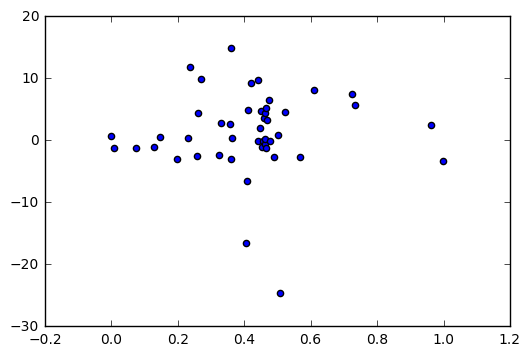

In [136]:
plt.scatter(test_df['pred'], test_df['week_later_gain'])

In [132]:
test_df

,event_label,target,week_later_gain,per_drop_from_yesterday,Date,ticker,vol_mean,vol_std,vol_amax,vol_amin,vol_slope,vol_intercept,norm_vol_std,norm_vol_amax,norm_vol_amin,norm_vol_slope,norm_vol_intercept,pred
0,7,0,0.793021,-5.471848,2017-09-25,AMD,93804780.0,4.525228e+07,166821900.0,50547000.0,-3542590.0,100889960.0,0.482409,1.778394,0.538853,-0.037766,1.075531,2.397107e-12
16,23,0,-1.189992,-8.309394,2017-09-15,ORCL,15319960.0,4.301594e+06,21901600.0,10356500.0,-2102690.0,19525340.0,0.280784,1.429612,0.676014,-0.137252,1.274503,8.795305e-03
37,44,0,-1.213918,-6.033629,2017-09-05,UTX,4352725.0,1.327674e+06,5572900.0,2644700.0,1001990.0,2849740.0,0.305021,1.280324,0.607596,0.230198,0.654703,7.326253e-02
14,21,0,-1.075992,-6.657700,2017-09-18,MAT,6165400.0,2.568027e+06,10218700.0,3800600.0,-1316780.0,8798960.0,0.416522,1.657427,0.616440,-0.213576,1.427152,1.276986e-01
5,12,0,0.498375,-6.152967,2017-09-20,GIS,4095080.0,1.508507e+06,6223900.0,2253800.0,-933150.0,5961380.0,0.368371,1.519848,0.550368,-0.227871,1.455742,1.460207e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,39,1,8.186275,-7.285082,2017-09-07,RE,819575.0,3.372219e+05,1195200.0,528800.0,-247230.0,1190420.0,0.411459,1.458317,0.645212,-0.301656,1.452485,6.112298e-01
34,41,1,7.565795,-5.400222,2017-09-07,XL,4075000.0,1.350349e+06,5923900.0,2944700.0,-655320.0,5057980.0,0.331374,1.453718,0.722626,-0.160815,1.241222,7.245287e-01
38,45,1,5.696371,-6.140577,2017-09-05,XL,2412575.0,7.742412e+05,3207700.0,1716000.0,-550610.0,3238490.0,0.320919,1.329575,0.711273,-0.228225,1.342338,7.325645e-01
25,32,0,2.421657,-8.119663,2017-09-08,KR,15250600.0,4.040042e+06,21085200.0,11780200.0,-2416240.0,18874960.0,0.264910,1.382582,0.772442,-0.158436,1.237654,9.637211e-01


In [114]:
feat_imps = pd.Series(index=X_train.columns, data=model.coef_[0])

#### On buy + volume prediction architecture
- stock data stream
- this program is constantly consuming data + producting buy + volume buy 
    - current volume decisions are super simple, just buy as much as $1000 allows